In [1]:
import os, sys, re, datetime, random, gzip, json
from tqdm.autonotebook import tqdm
import pandas as pd
import numpy as np
import glob
from pathlib import Path
from itertools import accumulate
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

from time import time
from math import ceil
from multiprocessing import Pool
from sentence_transformers import SentenceTransformer, models, losses, InputExample

import pytorch_lightning as pl
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.utilities.seed import seed_everything

PROJ_PATH = Path(os.path.join(re.sub("/BERT_ABSA.*$", '', os.getcwd()), 'BERT_ABSA'))
print(f'PROJ_PATH={PROJ_PATH}')
sys.path.insert(1, str(PROJ_PATH))
sys.path.insert(1, str(PROJ_PATH/'src'))
import utils
import matplotlib.pyplot as plt

%matplotlib inline

/tmp/ipykernel_2477997/2032842600.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


PROJ_PATH=/home/hoang/github/BERT_ABSA


In [2]:
# glob.glob('../model/restaurants/*.ckpt')

## Utils

In [5]:
import nltk
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error
from scipy.stats import pearsonr

def tokenization(text):
    text = text.strip().lower()
    tokens = nltk.word_tokenize(text)
    return tokens

def bucketize(text_length):
    if text_length < 15:
        return 0
    elif text_length < 20:
        return 1
    elif text_length < 30:
        return 2
    else:
        return 3
def get_pred_label(x):
    if max([x.pred_0, x.pred_1, x.pred_2]) == x.pred_0:
        return 'negative'
    elif max([x.pred_0, x.pred_1, x.pred_2]) == x.pred_1:
        return 'neutral'
    else: return 'positive'
    
def get_pred_label_id(x):
    if max([x.pred_0, x.pred_1, x.pred_2]) == x.pred_0:
        return 0
    elif max([x.pred_0, x.pred_1, x.pred_2]) == x.pred_1:
        return 1
    else: return 2
    
def read_base_prediction(dataset='restaurant'):
    model_dict = {
        'bert': '../output/bert_{}.csv'.format(dataset),
        'syn': '../output/syn_{}.csv'.format(dataset),
        'sem': '../output/sem_{}.csv'.format(dataset),
    }
    
    tmp = [pd.read_csv(list(model_dict.values())[0])[['id', 'text', 'term', 'label_id', 'label', 'tvt']]]
    for n, p in model_dict.items():
        tmp.append(pd.read_csv(p)[['pred_0', 'pred_1', 'pred_2']].rename(columns={
            'pred_0': f'{n}_0', 'pred_1': f'{n}_1', 'pred_2': f'{n}_2'}))
    df = pd.concat(tmp, axis=1)
    df['label_id'] = df['label'].map({j:i for i,j in labelid2str.items()})
    df['tokens'] = df['text'].apply(tokenization)
    df['text_length'] = df['tokens'].apply(lambda x: len(x))
    df['length_group'] = df['text_length'].apply(bucketize)
    
    df['is_neg'] = df['label_id'].apply(lambda x: int(x==0))
    df['is_neu'] = df['label_id'].apply(lambda x: int(x==1))
    df['is_pos'] = df['label_id'].apply(lambda x: int(x==2))
    return df

In [3]:
def get_tvt_idx(df, tvt_col='tvt'):
    '''
    Get train/val/test indexes
    
    Returns
    -------
        [('train', train_idx), ('val', val_idx), ('test', test_idx)]
        
    '''
    tvt_idx = [
        ('train', df['tvt']=='train'),
        ('val', df['tvt']=='val'),
        ('test', df['tvt']=='test'),
    ]
    return tvt_idx  

def get_feature_importance_from_model(fmodel, sort=True):
    model = fmodel['model']
    feature_cnames = fmodel['cname_feats']
    pd_imp = pd.DataFrame(list(model.get_booster().get_score(importance_type='gain').items()), columns=['feature', 'importance'])
    pd_imp['feature'] = pd_imp['feature'].replace({'f{}'.format(str(i)): feature_cnames[i] for i in range(len(feature_cnames))}) # for ranker
    if sort:
        pd_imp = pd_imp.sort_values('importance', ascending=False)
    return pd_imp

def compute_evaluation_metrics(model, best_ntree, x_train, y_train, x_val, y_val, x_test, y_test, is_binary):
    train_score = model.predict_proba(x_train, ntree_limit=best_ntree)
    train_pred = model.predict(x_train, ntree_limit=best_ntree)
    val_score = model.predict_proba(x_val, ntree_limit=best_ntree)
    val_pred = model.predict(x_val, ntree_limit=best_ntree)
    test_score = model.predict_proba(x_test, ntree_limit=best_ntree)
    test_pred = model.predict(x_test, ntree_limit=best_ntree)
    
    if is_binary:
        train_auc = roc_auc_score(y_true=y_train, y_score=train_score[:, 1])
        val_auc = roc_auc_score(y_true=y_val, y_score=val_score[:, 1])
        test_auc = roc_auc_score(y_true=y_test, y_score=test_score[:, 1])
    else:
        train_auc = roc_auc_score(y_true=y_train, y_score=train_score, multi_class='ovo')
        val_auc = roc_auc_score(y_true=y_val, y_score=val_score, multi_class='ovo')
        test_auc = roc_auc_score(y_true=y_test, y_score=test_score, multi_class='ovo')
    
    train_acc = accuracy_score(y_true=y_train, y_pred=train_pred)
    val_acc = accuracy_score(y_true=y_val, y_pred=val_pred)
    test_acc = accuracy_score(y_true=y_test, y_pred=test_pred)
    return train_auc, train_acc, val_auc, val_acc, test_auc, test_acc

def train_xgb(dfXY, tvt_idx, cname_feats, cname_target='label', option_init={}, option_fit={}):
    default_option_fit = {
        'eval_metric': 'auc',
        'verbose': False,
        'early_stopping_rounds': 20,
    }
    default_option_init = {
        'objective': 'binary:logistic',
#         'max_depth': 5,
#         'n_estimators': 200,   
#         'learning_rate': 0.001,
#         'gamma': 0.0,
#         'min_child_weight': 10,
#         'subsample': 0.1,
#         'tree_method': 'hist',
#         'colsample_bytree': 0.5,
#         'colsample_bylevel': 0.5,
#         'reg_alpha': 0.0,
#         'reg_lambda': 1.0,
        'random_state': 0,
        'n_jobs': 32
    }
    default_option_fit.update(option_fit)
    default_option_init.update(option_init)
    option_fit = default_option_fit
    option_init = default_option_init
    
    if dfXY[cname_target].nunique() == 2:
        is_binary = True
    else:
        is_binary = False
    # train/test
    x_train = dfXY[tvt_idx[0][1]][cname_feats].values
    y_train = dfXY[tvt_idx[0][1]][cname_target].values.astype("i4")
    x_val = dfXY[tvt_idx[1][1]][cname_feats].values
    y_val = dfXY[tvt_idx[1][1]][cname_target].values.astype("i4")
    x_test = dfXY[tvt_idx[2][1]][cname_feats].values
    y_test = dfXY[tvt_idx[2][1]][cname_target].values.astype("i4")
    
    # classify
    eval_set = [
        (x_train, y_train),
        (x_val, y_val),
    ]
    
    model = xgb.XGBClassifier(**option_init)
    model.fit(x_train, y_train, eval_set=eval_set, **option_fit)
    best_ntree = model.get_booster().best_ntree_limit  
    
    train_auc, train_acc, val_auc, val_acc, test_auc, test_acc = compute_evaluation_metrics(
        model, best_ntree, x_train, y_train, x_val, y_val, x_test, y_test, is_binary)
    print('n_features n_train n_val n_test n_tree train_auc train_acc val_auc val_acc test_auc test_acc')
    print('{} {} {} {} {} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}'.format(
        len(cname_feats), x_train.shape[0], x_val.shape[0], x_test.shape[0], best_ntree,
        train_auc, train_acc, val_auc, val_acc, test_auc, test_acc))
    
    # track
    fmodel = {
        'model': model,
        'cname_target': cname_target,
        'cname_feats': cname_feats,  
    }
    return fmodel

def compute_evaluation_metrics_reg(model, best_ntree, x_train, y_train, x_val, y_val, x_test, y_test):
    pred_train = model.predict(x_train, ntree_limit=best_ntree)
    pred_val = model.predict(x_val, ntree_limit=best_ntree)
    pred_test = model.predict(x_test, ntree_limit=best_ntree)
    
    mse_train = mean_squared_error(y_true=y_train, y_pred=pred_train)
    corr_train = pearsonr(y_train, pred_train)[0]
    mse_val = mean_squared_error(y_true=y_val, y_pred=pred_val)
    corr_val = pearsonr(y_val, pred_val)[0]
    mse_test = mean_squared_error(y_true=y_test, y_pred=pred_test)
    corr_test = pearsonr(y_test, pred_test)[0]
    return mse_train, corr_train, mse_val, corr_val, mse_test, corr_test

def train_xgb_regressor(dfXY, tvt_idx, cname_feats, cname_target='label', option_init={}, option_fit={}):
    default_option_fit = {
        'eval_metric': 'rmse',
        'verbose': False,
        'early_stopping_rounds': 20,
    }
    default_option_init = {
        'objective': 'reg:squarederror',
#         'max_depth': 5,
#         'n_estimators': 200,   
#         'learning_rate': 0.001,
#         'gamma': 0.0,
#         'min_child_weight': 10,
#         'subsample': 0.1,
#         'tree_method': 'hist',
#         'colsample_bytree': 0.5,
#         'colsample_bylevel': 0.5,
#         'reg_alpha': 0.0,
#         'reg_lambda': 1.0,
        'random_state': 0,
        'n_jobs': 32
    }
    default_option_fit.update(option_fit)
    default_option_init.update(option_init)
    option_fit = default_option_fit
    option_init = default_option_init
    
    # train/test
    x_train = dfXY[tvt_idx[0][1]][cname_feats].values
    y_train = dfXY[tvt_idx[0][1]][cname_target].values.astype("i4")
    x_val = dfXY[tvt_idx[1][1]][cname_feats].values
    y_val = dfXY[tvt_idx[1][1]][cname_target].values.astype("i4")
    x_test = dfXY[tvt_idx[2][1]][cname_feats].values
    y_test = dfXY[tvt_idx[2][1]][cname_target].values.astype("i4")
    
    # classify
    eval_set = [
        (x_train, y_train),
        (x_val, y_val),
    ]
    
    model = xgb.XGBRegressor(**option_init)
    model.fit(x_train, y_train, eval_set=eval_set, **option_fit)
    best_ntree = model.get_booster().best_ntree_limit  
    
    mse_train, corr_train, mse_val, corr_val, mse_test, corr_test = compute_evaluation_metrics_reg(
        model, best_ntree, x_train, y_train, x_val, y_val, x_test, y_test)
    print('n_features n_train n_val n_test n_tree mse_train corr_train mse_val corr_val mse_test corr_test')
    print('{} {} {} {} {} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}'.format(
        len(cname_feats), x_train.shape[0], x_val.shape[0], x_test.shape[0], best_ntree,
        mse_train, corr_train, mse_val, corr_val, mse_test, corr_test))
   
    # track
    fmodel = {
        'model': model,
        'cname_target': cname_target,
        'cname_feats': cname_feats,  
    }
    return fmodel

## Quick EDA

In [66]:
df_res = pd.read_csv('../output/bert_restaurant.csv')
df_res['ds'] = 'restaurants'
df_lap = pd.read_csv('../output/bert_laptop.csv')
df_lap['ds'] = 'laptops'
df = pd.concat([df_res, df_lap])

df.pivot_table(index='ds', columns=['label', 'tvt'], values='id', aggfunc='count')

label       negative            neutral            positive           
tvt             test train  val    test train  val     test train  val
ds                                                                    
laptops          128   693  177     169   382   82      341   787  207
restaurants      196   647  160     196   500  137      728  1739  425

[(0, 2.0), (10, 9.0), (20, 11.0), (30, 14.0), (40, 16.0), (50, 18.0), (60, 20.0), (70, 23.0), (80, 27.0), (90, 32.0), (100, 79.0)]


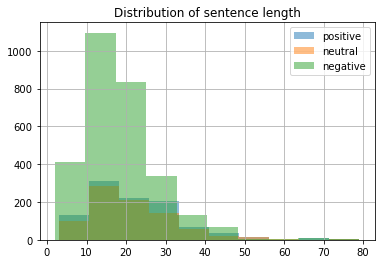

pred_label,negative,neutral,positive
label,,,
negative,921,52,30
neutral,79,681,73
positive,59,99,2734


In [70]:
df = pd.read_csv('../output/bert_restaurant.csv')
labelid2str = {0: 'negative', 1: 'neutral', 2: 'positive'}
df['label_id'] = df['label'].map({j:i for i,j in labelid2str.items()})
df['pred_label'] = df[['pred_0', 'pred_1', 'pred_2']].apply(get_pred_label, axis=1)
df['pred_id'] = df['pred_label'].map({j:i for i,j in labelid2str.items()})
df['tokens'] = df['text'].apply(tokenization)
df['text_length'] = df['tokens'].apply(lambda x: len(x))


p = range(0, 101, 10)
print(list(zip(p, np.percentile(df['text_length'], p))))


i1 = df['label']=='negative'
i2 = df['label']=='neutral'
i3 = df['label']=='positive'
col = 'text_length'
df[i1][col].hist(alpha=0.5, label='positive')
df[i2][col].hist(alpha=0.5, label='neutral')
df[i3][col].hist(alpha=0.5, label='negative')
plt.legend()
plt.title('Distribution of sentence length')
plt.show()

pred_results = df.groupby(['label', 'pred_label'], as_index=False).size().sort_values('size', ascending=False)
display(pred_results.pivot_table(index='label', columns='pred_label', values='size', aggfunc='sum'))

[(0, 3.0), (10, 9.0), (20, 12.0), (30, 14.0), (40, 16.0), (50, 19.0), (60, 21.0), (70, 24.0), (80, 29.0), (90, 37.0), (100, 83.0)]


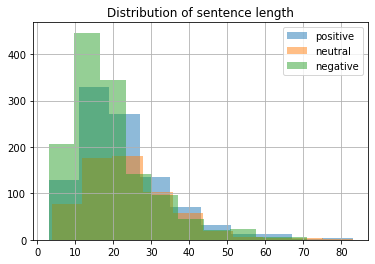

pred_label,negative,neutral,positive
label,,,
negative,924,36,38
neutral,88,504,41
positive,48,53,1234


In [72]:
df = pd.read_csv('../output/bert_laptop.csv')
labelid2str = {0: 'negative', 1: 'neutral', 2: 'positive'}
df['label_id'] = df['label'].map({j:i for i,j in labelid2str.items()})
df['pred_label'] = df[['pred_0', 'pred_1', 'pred_2']].apply(get_pred_label, axis=1)
df['pred_id'] = df['pred_label'].map({j:i for i,j in labelid2str.items()})
df['tokens'] = df['text'].apply(tokenization)
df['text_length'] = df['tokens'].apply(lambda x: len(x))


p = range(0, 101, 10)
print(list(zip(p, np.percentile(df['text_length'], p))))


i1 = df['label']=='negative'
i2 = df['label']=='neutral'
i3 = df['label']=='positive'
col = 'text_length'
df[i1][col].hist(alpha=0.5, label='positive')
df[i2][col].hist(alpha=0.5, label='neutral')
df[i3][col].hist(alpha=0.5, label='negative')
plt.legend()
plt.title('Distribution of sentence length')
plt.show()

pred_results = df.groupby(['label', 'pred_label'], as_index=False).size().sort_values('size', ascending=False)
display(pred_results.pivot_table(index='label', columns='pred_label', values='size', aggfunc='sum'))

In [71]:
# col1 = 'pred_0'
# col2 = 'pred_1'
# col3 = 'pred_2'
# df[i1][col1].hist(alpha=0.5, label='positive')
# df[i1][col2].hist(alpha=0.5, label='negative')
# df[i1][col3].hist(alpha=0.5, label='neutral')
# plt.legend()
# plt.title('Distribution of prediction for positive sentences')
# plt.show()

# i1 = df['label']=='positive'
# i2 = df['label']=='neutral'
# i3 = df['label']=='negative'
# col1 = 'pred_0'
# col2 = 'pred_1'
# col3 = 'pred_2'
# df[i2][col1].hist(alpha=0.5, label='positive')
# df[i2][col2].hist(alpha=0.5, label='negative')
# df[i2][col3].hist(alpha=0.5, label='neutral')
# plt.legend()
# plt.title('Distribution of prediction for neutral sentences')
# plt.show()


# i1 = df['label']=='positive'
# i2 = df['label']=='neutral'
# i3 = df['label']=='negative'
# col1 = 'pred_0'
# col2 = 'pred_1'
# col3 = 'pred_2'
# df[i3][col1].hist(alpha=0.5, label='positive')
# df[i3][col2].hist(alpha=0.5, label='negative')
# df[i3][col3].hist(alpha=0.5, label='neutral')
# plt.legend()
# plt.title('Distribution of prediction for negative sentences')
# plt.show()

## Ensemble learning - restaurant

In [7]:
labelid2str = {0: 'negative', 1: 'neutral', 2: 'positive'}
df = read_base_prediction()
df.head()

,id,text,term,label_id,label,tvt,bert_0,bert_1,bert_2,syn_0,...,syn_2,sem_0,sem_1,sem_2,tokens,text_length,length_group,is_neg,is_neu,is_pos
0,1909,The entire dining experience was wonderful!,dining experience,2,positive,train,0.000114,0.000763,0.999123,0.000153,...,0.999390,0.001158,0.001646,0.997196,"[the, entire, dining, experience, was, wonderf...",7,0,0,0,1
1,2492,The chicken and steak were seasoned and cooked...,steak,2,positive,train,0.000115,0.000770,0.999115,0.000141,...,0.999435,0.000971,0.001588,0.997441,"[the, chicken, and, steak, were, seasoned, and...",21,2,0,0,1
2,1894,The place is a BISTRO which means: simple dish...,wine,2,positive,train,0.000120,0.000800,0.999080,0.000207,...,0.999155,0.001224,0.001519,0.997257,"[the, place, is, a, bistro, which, means, :, s...",19,1,0,0,1
3,2871,"Leon is an East Village gem: casual but hip, w...",atmosphere,2,positive,train,0.000114,0.000760,0.999126,0.000140,...,0.999442,0.001197,0.001547,0.997257,"[leon, is, an, east, village, gem, :, casual, ...",28,2,0,0,1
4,2449,The Waitstaff were very nice and suggested swo...,swordfish,2,positive,train,0.000715,0.006762,0.992523,0.000598,...,0.997352,0.000509,0.005073,0.994418,"[the, waitstaff, were, very, nice, and, sugges...",16,1,0,0,1


In [9]:
model_name = ['bert', 'syn', 'sem']
i_test = df['tvt']=='test'
for n in model_name:
    print(n)
    tmp = df.copy()
    tmp = tmp.rename(columns={f'{n}_0': 'pred_0', f'{n}_1': 'pred_1', f'{n}_2': 'pred_2'})
    tmp['pred_label'] = tmp[['pred_0', 'pred_1', 'pred_2']].apply(get_pred_label, axis=1)
    tmp['pred_id'] = tmp['pred_label'].map({j:i for i,j in labelid2str.items()})
    test_auc = roc_auc_score(
        y_true=tmp[i_test]['label_id'], y_score=tmp[i_test][['pred_0', 'pred_1', 'pred_2']], multi_class='ovo')
    test_acc = accuracy_score(y_true=tmp[i_test]['label_id'], y_pred=tmp[i_test].apply(get_pred_label_id, axis=1))
    test_corr = pearsonr(tmp[i_test]['label_id'], tmp[i_test].apply(get_pred_label_id, axis=1))[0]
    print(f'Test AUC: {test_auc}')
    print(f'Test ACC: {test_acc}')
    print(f'Test CORR: {test_corr}\n')

bert
Test AUC: 0.9215537863497048
Test ACC: 0.8428571428571429
Test CORR: 0.7830828503354347

syn
Test AUC: 0.9186951517263107
Test ACC: 0.85
Test CORR: 0.7903537333835158

sem
Test AUC: 0.9137618940825938
Test ACC: 0.8526785714285714
Test CORR: 0.8006081889166599



In [10]:
excl_cols = ['id', 'text', 'term', 'label_id', 'label', 'tvt', 'tokens', 'is_neg', 'is_neu', 'is_pos']

In [32]:
tvt_idx = get_tvt_idx(df)
cname_feats = sorted([c for c in df.columns if c not in excl_cols and not c.startswith('pred_')])
option_init = {
    'n_estimators': 1000,
    'learning_rate': 0.001,
    'max_depth': 8,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'colsample_bylevel': 0.3,
    'random_state': 0,
}
fmodel_clf = train_xgb(
    dfXY=df, tvt_idx=tvt_idx, cname_feats=cname_feats, cname_target='label_id', option_init=option_init)
display(get_feature_importance_from_model(fmodel_clf))
if False:
    pd.to_pickle(fmodel_clf, '../model/ensemble_restaurants.pkl')

n_features n_train n_val n_test n_tree train_auc train_acc val_auc val_acc test_auc test_acc
11 2886 722 1120 22 0.99855 0.99272 0.89788 0.80332 0.91885 0.86696


/home/hoang/miniconda2/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hoang/miniconda2/envs/py38/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


,feature,importance
6,sem_2,120.978851
5,sem_1,98.217224
9,syn_2,85.261421
0,bert_0,79.796188
4,sem_0,79.204941
7,syn_0,70.555641
2,bert_2,65.485435
1,bert_1,59.234016
8,syn_1,56.462891
10,text_length,1.364058


## Ensemble learning - Laptop

In [74]:
labelid2str = {0: 'negative', 1: 'neutral', 2: 'positive'}
df = read_base_prediction('laptop')
df.head()

,id,text,term,label_id,label,tvt,bert_0,bert_1,bert_2,syn_0,...,syn_2,sem_0,sem_1,sem_2,tokens,text_length,length_group,is_neg,is_neu,is_pos
0,2970,I did not have to call the support line at all.,support line,1,neutral,train,0.013033,0.977031,0.009937,0.024876,...,0.078817,0.001159,0.997346,0.001495,"[i, did, not, have, to, call, the, support, li...",12,0,0,1,0
1,2338,I take it everywhere with me because it's so e...,carry,2,positive,train,0.007021,0.011967,0.981011,0.000242,...,0.994666,0.000404,0.000521,0.999075,"[i, take, it, everywhere, with, me, because, i...",14,0,0,0,1
2,2674,One drawback I noticed was sound quality via USB.,sound quality via USB,0,negative,train,0.972162,0.006145,0.021693,0.981453,...,0.005989,0.997571,0.001612,0.000817,"[one, drawback, i, noticed, was, sound, qualit...",10,0,1,0,0
3,3011,"Great OS, fabulous improvements to the existin...",OS,2,positive,train,0.013200,0.043205,0.943595,0.000195,...,0.997985,0.000541,0.000386,0.999073,"[great, os, ,, fabulous, improvements, to, the...",20,2,0,0,1
4,76,"I even got my teenage son one, because of the ...",Photobooth,2,positive,train,0.007652,0.007146,0.985201,0.000148,...,0.997125,0.000435,0.000465,0.999099,"[i, even, got, my, teenage, son, one, ,, becau...",27,2,0,0,1


In [75]:
model_name = ['bert', 'syn', 'sem']
i_test = df['tvt']=='test'
for n in model_name:
    print(n)
    tmp = df.copy()
    tmp = tmp.rename(columns={f'{n}_0': 'pred_0', f'{n}_1': 'pred_1', f'{n}_2': 'pred_2'})
    tmp['pred_label'] = tmp[['pred_0', 'pred_1', 'pred_2']].apply(get_pred_label, axis=1)
    tmp['pred_id'] = tmp['pred_label'].map({j:i for i,j in labelid2str.items()})
    test_auc = roc_auc_score(
        y_true=tmp[i_test]['label_id'], y_score=tmp[i_test][['pred_0', 'pred_1', 'pred_2']], multi_class='ovo')
    test_acc = accuracy_score(y_true=tmp[i_test]['label_id'], y_pred=tmp[i_test].apply(get_pred_label_id, axis=1))
    test_corr = pearsonr(tmp[i_test]['label_id'], tmp[i_test].apply(get_pred_label_id, axis=1))[0]
    print(f'Test AUC: {test_auc}')
    print(f'Test ACC: {test_acc}')
    print(f'Test CORR: {test_corr}\n')

bert
Test AUC: 0.8988439703390075
Test ACC: 0.7774294670846394
Test CORR: 0.72685876734475

syn
Test AUC: 0.8894568779029077
Test ACC: 0.7789968652037618
Test CORR: 0.7328292725606129

sem
Test AUC: 0.8899405753469029
Test ACC: 0.7899686520376176
Test CORR: 0.725577290338284



In [76]:
excl_cols = ['id', 'text', 'term', 'label_id', 'label', 'tvt', 'tokens', 'is_neg', 'is_neu', 'is_pos']

In [81]:
tvt_idx = get_tvt_idx(df)
cname_feats = sorted([c for c in df.columns if c not in excl_cols and not c.startswith('pred_')])
option_init = {
    'n_estimators': 1000,
    'learning_rate': 0.001,
    'max_depth': 8,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'colsample_bylevel': 0.3,
}
fmodel_clf = train_xgb(
    dfXY=df, tvt_idx=tvt_idx, cname_feats=cname_feats, cname_target='label_id', option_init=option_init)
display(get_feature_importance_from_model(fmodel_clf))
if False:
    pd.to_pickle(fmodel_clf, '../model/ensemble_laptops.pkl')

n_features n_train n_val n_test n_tree train_auc train_acc val_auc val_acc test_auc test_acc
11 1862 466 638 21 0.99885 0.98711 0.90881 0.78755 0.89483 0.79781


/home/hoang/miniconda2/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hoang/miniconda2/envs/py38/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


,feature,importance
7,syn_0,81.614334
8,syn_1,70.301811
9,syn_2,65.288406
6,sem_2,63.876202
4,sem_0,58.641983
2,bert_2,53.528976
0,bert_0,51.229324
1,bert_1,48.101238
5,sem_1,43.510239
10,text_length,1.050979


In [79]:
tvt_idx = get_tvt_idx(df)
cname_feats = sorted([c for c in df.columns if c not in excl_cols and c not in ])
option_init = {
    'n_estimators': 1000,
    'learning_rate': 0.001,
    'max_depth': 8,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'colsample_bylevel': 0.3,
#     'random_state': 0,
}
fmodel_clf = train_xgb(
    dfXY=df, tvt_idx=tvt_idx, cname_feats=cname_feats, cname_target='label_id', option_init=option_init)
display(get_feature_importance_from_model(fmodel_clf))

n_features n_train n_val n_test n_tree train_auc train_acc val_auc val_acc test_auc test_acc
14 1862 466 638 8 0.99870 0.98980 0.89541 0.78112 0.88822 0.79154


/home/hoang/miniconda2/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hoang/miniconda2/envs/py38/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


,feature,importance
7,sem_0,108.387306
10,syn_0,106.763435
12,syn_2,100.280754
4,pred_neg,97.356911
6,pred_pos,92.012566
0,bert_0,73.423386
9,sem_2,72.179443
2,bert_2,70.953064
11,syn_1,59.743412
5,pred_neu,53.850788


## Misc

In [84]:
# tvt_idx = get_tvt_idx(df)
# cname_feats = sorted([c for c in df.columns if c not in excl_cols and not c.startswith('pred_')])
# option_init = {
#     'n_estimators': 1000,
#     'learning_rate': 0.001,
#     'subsample': 0.9,
#     'colsample_bytree': 0.9,
#     'colsample_bylevel': 0.9,
#     'random_state': 0,
# }
# fmodel_neg = train_xgb(
#     dfXY=df, tvt_idx=tvt_idx, cname_feats=cname_feats, cname_target='is_neg', option_init=option_init)

# tvt_idx = get_tvt_idx(df)
# cname_feats = sorted([c for c in df.columns if c not in excl_cols and not c.startswith('pred_')])
# option_init = {
#     'n_estimators': 1000,
#     'learning_rate': 0.001,
#     'subsample': 0.9,
#     'colsample_bytree': 0.9,
#     'colsample_bylevel': 0.9,
#     'random_state': 0,
# }
# fmodel_neu = train_xgb(
#     dfXY=df, tvt_idx=tvt_idx, cname_feats=cname_feats, cname_target='is_neu', option_init=option_init)

# tvt_idx = get_tvt_idx(df)
# cname_feats = sorted([c for c in df.columns if c not in excl_cols and not c.startswith('pred_')])
# option_init = {
#     'n_estimators': 1000,
#     'learning_rate': 0.001,
#     'subsample': 0.9,
#     'colsample_bytree': 0.9,
#     'colsample_bylevel': 0.9,
#     'random_state': 0,
# }
# fmodel_pos = train_xgb(
#     dfXY=df, tvt_idx=tvt_idx, cname_feats=cname_feats, cname_target='is_pos', option_init=option_init)

# df['pred_neg'] = fmodel_neg['model'].predict_proba(df[fmodel_neg['cname_feats']])[:, 1]
# df['pred_neu'] = fmodel_neu['model'].predict_proba(df[fmodel_neu['cname_feats']])[:, 1]
# df['pred_pos'] = fmodel_pos['model'].predict_proba(df[fmodel_pos['cname_feats']])[:, 1]

In [ ]:
# tvt_idx = get_tvt_idx(df)
# cname_feats = sorted([c for c in df.columns if c not in excl_cols])
# print(cname_feats)
# option_init = {
#     'n_estimators': 20000,
#     'learning_rate': 0.001,
#     'subsample': 0.9,
#     'colsample_bytree': 0.7,
#     'colsample_bylevel': 0.7,
#     'random_state': 0,
# }
# fmodel = train_xgb_regressor(
#     dfXY=df, tvt_idx=tvt_idx, cname_feats=cname_feats, cname_target='label_id', option_init=option_init)
# display(get_feature_importance_from_model(fmodel))

In [85]:
# df['reg'] = fmodel['model'].predict(df[fmodel['cname_feats']])
# i_neg = (df['label_id']==0)
# i_neu = (df['label_id']==1)
# i_pos = (df['label_id']==2)

# i_train = (df['tvt']=='train')
# i_val = (df['tvt']=='val')
# i_test = (df['tvt']=='test')
# col = 'reg'
# fig, ax = plt.subplots(figsize=(15, 7))
# df[i_neg&(i_train|i_val)][col].hist(bins=100, alpha=0.5, label='Negative', density=True, ax=ax)
# df[i_neu&(i_train|i_val)][col].hist(bins=100, alpha=0.5, label='Neutral', density=True, ax=ax)
# df[i_pos&(i_train|i_val)][col].hist(bins=100, alpha=0.5, label='Positive', density=True, ax=ax)
# plt.title('Histogram of Regression')
# plt.legend(loc='upper right')
# plt.show()

In [120]:
# def get_XYG(pdXY, features, target, query_id):
#     z = pdXY.sort_values(query_id)
#     X = z[features].values
#     Y = z[target].values
#     G = list(pdXY.groupby(query_id).size())
#     return X,Y,G

# def compute_evaluation_metrics(model, best_ntree, x_train, y_train, x_val, y_val, x_test, y_test):
# #     train_score = model.predict_proba(x_train, ntree_limit=best_ntree)
#     train_pred = model.predict(x_train, ntree_limit=best_ntree)
# #     val_score = model.predict_proba(x_val, ntree_limit=best_ntree)
#     val_pred = model.predict(x_val, ntree_limit=best_ntree)
# #     test_score = model.predict_proba(x_test, ntree_limit=best_ntree)
#     test_pred = model.predict(x_test, ntree_limit=best_ntree)
#     print(train_pred)
#     train_auc = roc_auc_score(y_true=y_train, y_score=train_pred)
#     train_acc = 0
#     val_auc = roc_auc_score(y_true=y_val, y_score=train_pred, multi_class='ovo')
#     val_acc = 0
#     test_auc = roc_auc_score(y_true=y_test, y_score=train_pred, multi_class='ovo')
#     test_acc = 0
#     return train_auc, train_acc, val_auc, val_acc, test_auc, test_acc

# def train_xgb_ranker(
#     dfXY, tvt_idx, cname_feats, cname_target='label', query_id='length_group', option_init={}, option_fit={}):
#     default_option_fit = {
#         'eval_metric': 'auc',
#         'verbose': False,
#         'early_stopping_rounds': 20,
#     }
#     default_option_init = {
#            'objective': 'rank:pairwise',
# #         'max_depth': 5,
# #         'n_estimators': 200,   
# #         'learning_rate': 0.001,
# #         'gamma': 0.0,
# #         'min_child_weight': 10,
# #         'subsample': 0.1,
# #         'tree_method': 'hist',
# #         'colsample_bytree': 0.5,
# #         'colsample_bylevel': 0.5,
# #         'reg_alpha': 0.0,
# #         'reg_lambda': 1.0,
#         'random_state': 0,
#         'n_jobs': 32
#     }
#     default_option_fit.update(option_fit)
#     default_option_init.update(option_init)
#     option_fit = default_option_fit
#     option_init = default_option_init
    
#     x_train, y_train, g_train = get_XYG(dfXY[tvt_idx[0][1]], cname_feats, cname_target, query_id)
#     x_val, y_val, g_val = get_XYG(dfXY[tvt_idx[1][1]], cname_feats, cname_target, query_id)
#     x_test, y_test, g_test = get_XYG(dfXY[tvt_idx[2][1]], cname_feats, cname_target, query_id)
    
#     eval_set = [
#         (x_train, y_train),
#         (x_val, y_val),
#     ]
#     eval_group = [g_train, g_val]
    
#     model = xgb.XGBRanker(**option_init)
#     model.fit(x_train, y_train, g_train, eval_set=eval_set, eval_group=eval_group, **option_fit)    
#     best_ntree = model.get_booster().best_ntree_limit  
    
#     train_auc, train_acc, val_auc, val_acc, test_auc, test_acc = compute_evaluation_metrics(
#         model, best_ntree, x_train, y_train, x_val, y_val, x_test, y_test)
#     print('n_features n_train n_val n_test n_tree train_auc train_acc val_auc val_acc test_auc test_acc')
#     print('{} {} {} {} {} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}'.format(
#         len(cname_feats), x_train.shape[0], x_val.shape[0], x_test.shape[0], best_ntree,
#         train_auc, train_acc, val_auc, val_acc, test_auc, test_acc))
    
#     # track
#     fmodel = {
#         'model': model,
#         'cname_target': cname_target,
#         'cname_feats': cname_feats,  
#     }
#     return fmodel

In [121]:
# fmodel = train_xgb_ranker(
#     dfXY=df, tvt_idx=tvt_idx, cname_feats=cname_feats, cname_target='label_id', option_init=option_init)
# display(get_feature_importance_from_model(fmodel))